In [21]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np


# Generate RX positions

distances_km = [8]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
angles = [(45, 90), (120, 80), (75,70),(80,70), (65, 85),(130,75)]
# angles = [(45, 90)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


TX0(m): [0. 0. 0.]
TX1(m): [ 4.89858591e-13  7.99999790e+03 -5.02275872e+00]

Satellite Pos [m]:
 [[ 2.38137915e-11  2.38137915e-11  5.50000000e+05]
 [ 8.38834990e+04 -4.84301607e+04  5.49322180e+05]
 [ 1.92355094e+05  5.15413921e+04  5.47134431e+05]
 [ 1.96115253e+05  3.45804104e+04  5.47134431e+05]
 [ 4.35971558e+04  2.03296876e+04  5.49832825e+05]
 [ 1.12573272e+05 -9.44601913e+04  5.48439683e+05]]

From TX0:
  SAT0: az=45.00°, el=90.00°, dist=550000.00 m, λ count ≈ 18333333.33
  SAT1: az=120.00°, el=80.00°, dist=557796.36 m, λ count ≈ 18593212.01
  SAT2: az=75.00°, el=70.00°, dist=582248.30 m, λ count ≈ 19408276.66
  SAT3: az=80.00°, el=70.00°, dist=582248.30 m, λ count ≈ 19408276.66
  SAT4: az=65.00°, el=85.00°, dist=551933.10 m, λ count ≈ 18397769.90
  SAT5: az=130.00°, el=75.00°, dist=567786.54 m, λ count ≈ 18926218.02

From TX1:
  SAT0: az=180.00°, el=89.17°, dist=550063.20 m, λ count ≈ 18335440.03
  SAT1: az=123.93°, el=79.57°, dist=558552.76 m, λ count ≈ 18618425.17
  SAT2: a

In [22]:
resp = requests.get(url, timeout=10)
print(resp.status_code, resp.headers.get("Content-Type"))
print(resp.text[:500])        # first few bytes — do you see <html> ?


403 text/html; charset=UTF-8
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1"/>
<title>403 - Forbidden: Access is denied.</title>
<style type="text/css">
<!--
body{margin:0;font-size:.7em;font-family:Verdana, Arial, Helvetica, sans-serif;background:#EEEEEE;}
fieldset{padding:0 15px 10px 15px;}
h1{font-size:2.4em;margin:0;color:#FFF;}


In [24]:
"""
Compute Starlink satellites that satisfy user-defined
elevation / azimuth / range constraints and express their
locations in a local ENU Cartesian frame whose origin is the
ground station (x = East, y = North, z = Up).

The user-defined jammer is listed **first** in the output table.
"""

import numpy as np
import pandas as pd
import requests
from skyfield.api import load, EarthSatellite, wgs84
from skyfield.framelib import itrs                     # Earth-fixed ITRF frame

# ───────────────────────────────────────────────────────────────
# 0) User-configurable parameters
# ----------------------------------------------------------------
# Satellite filters
ELEV_MIN_DEG   = 10           # minimum elevation (deg)
AZ_RANGE_DEG   = (0, 360)     # azimuth window [start, end)
MAX_SLANT_KM   = 9_999        # maximum slant range (km)
MAX_SAT_NUMBER = 200          # first N TLEs for speed

# Jammer polar coordinates (local topocentric)
AZ_JAMMER_DEG = 45.0          # 0° = North, 90° = East
R_JAMMER_KM   = 50.0          # horizontal distance (km)
ALT_JAMMER_M  = 0.0           # altitude above local horizon (m)

# ───────────────────────────────────────────────────────────────
# 1) Observer definition (Boulder, CO)
# ----------------------------------------------------------------
lat, lon, elev = 40.0822, -105.1092, 1_560            # metres
ts  = load.timescale()
t   = ts.now()
topos = wgs84.latlon(lat, lon, elev)

# Build ECEF → ENU rotation matrix
phi = np.radians(lat)
lam = np.radians(lon)
R_ecef2enu = np.array([
    [-np.sin(lam),              np.cos(lam),               0.0],
    [-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam),  np.cos(phi)],
    [ np.cos(phi)*np.cos(lam),  np.cos(phi)*np.sin(lam),  np.sin(phi)]
])

# ───────────────────────────────────────────────────────────────
# 2) Build jammer row FIRST
# ----------------------------------------------------------------
az_rad = np.radians(AZ_JAMMER_DEG)
r_m    = R_JAMMER_KM * 1_000

jammer_enu = np.array([
    r_m * np.sin(az_rad),     # x_East
    r_m * np.cos(az_rad),     # y_North
    ALT_JAMMER_M              # z_Up
])

rows = [[
    "JAMMER",
    AZ_JAMMER_DEG,
    0.0,                      # elevation undefined
    R_JAMMER_KM,
    *np.round(jammer_enu, 1)
]]

# ───────────────────────────────────────────────────────────────
# 3) Download Starlink TLEs and append satellites
# ----------------------------------------------------------------
# url = "https://celestrak.com/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"  # ← 换成 .org
HEADERS = {"User-Agent": "sat-tracker/1.0 (+https://github.com/you/repo)"}
tle_lines = requests.get(url, timeout=10).text.strip().splitlines()
sats = [
    (tle_lines[i].strip(),
     EarthSatellite(tle_lines[i+1], tle_lines[i+2], tle_lines[i].strip(), ts))
    for i in range(0, len(tle_lines), 3)
][:MAX_SAT_NUMBER]

for name, sat in sats:
    # (a) Topocentric angles and slant distance
    alt, az, dist = (sat - topos).at(t).altaz()
    slant_km      = dist.km

    # (b) Filters
    if alt.degrees < ELEV_MIN_DEG:
        continue
    if not (AZ_RANGE_DEG[0] <= az.degrees < AZ_RANGE_DEG[1]):
        continue
    if slant_km > MAX_SLANT_KM:
        continue

    # (c) Satellite & observer ECEF positions (metres)
    sat_ecef = sat.at(t).frame_xyz(itrs).m
    obs_ecef = topos.at(t).frame_xyz(itrs).m

    # (d) Convert to local ENU (station-centric)
    enu = R_ecef2enu @ (sat_ecef - obs_ecef)

    rows.append([
        name,
        round(az.degrees, 2),
        round(alt.degrees, 2),
        round(slant_km,   1),
        *np.round(enu, 1)
    ])

columns = ["Name", "Azimuth (°)", "Elevation (°)", "Slant km",
           "x_East (m)", "y_North (m)", "z_Up (m)"]
df = pd.DataFrame(rows, columns=columns)

print(df.to_string(index=False))


IndexError: list index out of range

In [25]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import vsat_dish_3gpp
import numpy as np
import math

jam_rows = 32
jam_cols = 32
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 32
tx_cols = 32
tx_antennas = tx_cols*tx_rows
# Create scene
scene = Scene()     

for tx_name in scene.transmitters:
    scene.remove(tx_name)
for rx_name in scene.receivers:
    scene.remove(rx_name)   
# Antenna pattern
scene.synthetic_array = True
scene.frequency = 10e9

tx_array = PlanarArray(num_rows=tx_rows ,
                        num_cols=tx_cols,
                        vertical_spacing=0.5,
                        horizontal_spacing=0.5,
                        pattern="tr38901",
                        polarization="V")

jam_array = PlanarArray(num_rows=jam_rows ,
                            num_cols=jam_cols,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows ,
                             num_cols=sat_cols,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")



# satellite as rx
scene.rx_array = sat_array
for i, pos in enumerate(sat_positions):
    # rx = Receiver(name=f"rx{i}", position=pos, orientation = [0, 180, 0])
    rx = Receiver(name=f"rx{i}", position=pos)
    scene.add(rx)

    rx.look_at(gnd_positions[0])
    
    
    



    
    

scene.tx_array = tx_array
tx = Transmitter(name=f"tx{0}", position=gnd_positions[0], display_radius=200)
scene.add(tx)
p_solver  = PathSolver()
paths = p_solver(scene=scene,
                 max_depth=0,
                 los=True,
                 synthetic_array=True,
                 seed=41)

# CIR analysis
a_tx, tau_tx = paths.cir(normalize_delays=False, out_type="numpy")

for tx_name in scene.transmitters:
    scene.remove(tx_name)

scene.tx_array = jam_array
tx = Transmitter(name=f"tx{1}", position=gnd_positions[1], display_radius=200)
scene.add(tx)
# tx.look_at(sat_positions[0])



p_solver  = PathSolver()
paths = p_solver(scene=scene,
                 max_depth=0,
                 los=True,
                 synthetic_array=True,
                 seed=41)


a_jam, tau_jam = paths.cir(normalize_delays=False, out_type="numpy")

H0 = a_tx[:, 0, 0, :, 0, 0]  
H1 = a_jam[:, 0, 0, :, 0, 0]  





In [26]:
H0.shape

(6, 1024)

In [27]:
import numpy as np
from scipy.linalg import eigh
def best_w0(H0, P):
    A = H0.conj().T @ np.linalg.inv(P) @ H0
    _, eigvecs = eigh(A)                 # ascending order
    w0 = eigvecs[:, -1]
    return w0

def best_w1(H0, H1, w0, N0, E1):
    a = H0 @ w0
    S = H1.conj().T @ np.outer(a, a.conj()) @ H1
    beta = E1 / N0
    C = np.eye(H1.shape[1]) + beta * (H1.conj().T @ H1)
    # largest gen-eigvec of (S,C)
    eigvals, eigvecs = eigh(S, C)
    w1 = eigvecs[:, -1]
    # q /= norm(q)
    return w1, E1 * np.outer(w1, w1.conj())

def jam_tx_game(H0, H1, N0, E0, E1, tol=1e-20,its=20):
    N0tx = H0.shape[1]
    N1tx = H1.shape[1]
    w0 = np.ones(N0tx) / np.sqrt(N0tx)
    w1 = np.ones(N1tx) / np.sqrt(N1tx)
    Q1 = E1 * np.outer(w1, w1.conj())
    P = H1 @ Q1 @ H1.conj().T + N0*np.eye(H0.shape[0])
    snr_hist = []
    for _ in range(its):
        
        w0 = best_w0(H0, P)
        w1, Q1 = best_w1(H0, H1, w0, N0, E1)
        P   = H1 @ Q1 @ H1.conj().T + N0 * np.eye(H0.shape[0])
        snr = E0 * np.real(w0.conj().T @ H0.conj().T @ np.linalg.inv(P) @ H0 @ w0)
        snr_hist.append(snr)
        # if len(snr_hist) > 1 and abs(snr_hist[-1] - snr_hist[-2]) / snr_hist[-1] < tol:
        #     break
    return w0, w1, snr, snr_hist


In [28]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  dBm
jam_power_dbm = 10
noise_figure_db = 5  # dB
k = 1.38e-23  # Boltzmann 
T = 150  # temperature in Kelvin
noise_power_db = 10 * np.log10(k * T * bandwidth)-30 + noise_figure_db
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)
N0_watt = 10 ** (noise_power_db / 10)      

In [29]:
w0_opt, w1_opt, snr, snr_curve = jam_tx_game(H0, H1, N0_watt, Tx_power_watt, jam_power_watt)

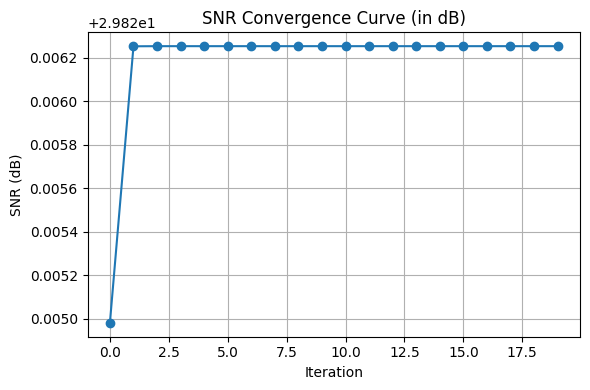

In [30]:
import matplotlib.pyplot as plt
snr_db = 10 * np.log10(np.array(snr_curve))

plt.figure(figsize=(6, 4))
plt.plot(snr_db, marker='o')
plt.xlabel("Iteration")
plt.ylabel("SNR (dB)")
plt.title("SNR Convergence Curve (in dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import cvxpy as cp

def compute_beamforming_vector(H, mode="eig1"):
    """
    Compute the transmit beamforming vector using one of:
    - 'eig1': Eigen-decomposition on unweighted Q
    - 'eig2': Eigen-decomposition on weighted Q (equalizes TX energy per direction)
    - 'avg' : Normalized average of effective channels
    - 'fair': Max-min fairness (equalize RX received energy)

    Parameters:
        H: numpy array of shape (N_rx, rx_antennas, N_tx, tx_antennas)
        mode: 'eig1', 'eig2', 'avg', or 'fair'

    Returns:
        w: Normalized beamforming vector of shape (tx_antennas, 1)
        norm_last_h_eff: Norm of last h_eff computed (debug/info)
    """
    N_rx, rx_antennas, N_tx, tx_antennas = H.shape
    assert N_tx == 1, "Only supports single TX (N_tx == 1)"

    w_r = np.ones((rx_antennas, 1), dtype=complex) / np.sqrt(rx_antennas)

    if mode in ("eig1", "eig2"):
        Q = np.zeros((tx_antennas, tx_antennas), dtype=complex)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :]           # (rx_antennas, tx_antennas)
            h_eff = H_rx.conj().T @ w_r     # (tx_antennas, 1)
            alpha = 1.0 / np.linalg.norm(h_eff)**2 if mode == "eig2" else 1.0
            Q += alpha * (h_eff @ h_eff.conj().T)
        eigvals, eigvecs = np.linalg.eigh(Q)
        w = eigvecs[:, -1]

    elif mode == "avg":
        w_sum = np.zeros((tx_antennas, 1), dtype=complex)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :]
            h_eff = H_rx.conj().T @ w_r
            h_eff_unit = h_eff / np.linalg.norm(h_eff)
            w_sum += h_eff_unit
        w = w_sum[:, 0]
        w /= np.linalg.norm(w)
    elif mode == "fair":
        w_var = cp.Variable((tx_antennas, 1), complex=True)
        t = cp.Variable()
        constraints = [cp.norm(w_var) <= 1]

        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :]              # (M, N)
            h_eff = H_rx.conj().T @ w_r        # (N, 1)
            A = h_eff @ h_eff.conj().T
            A = (A + A.conj().T) / 2           # Force Hermitian
            expr = cp.real(cp.matmul(cp.matmul(w_var.H, A), w_var))[0, 0]
            constraints.append(expr >= t)

        problem = cp.Problem(cp.Maximize(t), constraints)
        problem.solve()
        w = w_var.value[:, 0]


    else:
        raise ValueError("mode must be 'eig1', 'eig2', 'avg', or 'fair'")

    w = w.reshape(-1, 1)
    return w, np.linalg.norm(h_eff)


In [32]:
H = a_jam[..., 0, 0]   
w1,h1 = compute_beamforming_vector(H, mode="eig1")  # unweighted eig
w2,h2= compute_beamforming_vector(H, mode="eig2")  # weighted eig
w3 ,h3= compute_beamforming_vector(H, mode="avg")   # avg sum
# w4 ,_= compute_beamforming_vector(H, mode="fair")   # 

In [33]:
def compute_rx_gains(H, w):
    """
    Compute beamforming gains at each RX.

    Parameters:
        H: shape (N_rx, rx_antennas, 1, tx_antennas)
        w: beamforming vector of shape (tx_antennas, 1)

    Returns:
        gains: numpy array of shape (N_rx,), each entry is a gain (scalar)
    """
    N_rx, rx_antennas, _, tx_antennas = H.shape
    w_r = np.ones((rx_antennas, 1), dtype=complex) / np.sqrt(rx_antennas)
    gains = np.zeros(N_rx)

    for rx in range(N_rx):
        H_rx = H[rx, :, 0, :]                       # (rx_antennas, tx_antennas)
        h_combined = w_r.conj().T @ H_rx @ w        # scalar (1×M) · (M×N) · (N×1)
        gains[rx] = np.abs(h_combined[0, 0])**2     # real-valued scalar

    return 10 * np.log10(gains )

In [34]:
w0 = np.ones((sat_antennas, 1), dtype=complex) / np.sqrt(sat_antennas)
gains0 = compute_rx_gains(H, w0)
gains1 = compute_rx_gains(H, w1)
gains2 = compute_rx_gains(H, w2)
gains3 = compute_rx_gains(H, w3)
print(gains0)
print(gains1)  # array of shape (N_rx,), each is beamforming gain
print(gains2)  # array of shape (N_rx,), each is beamforming gain
print(gains3)  # array of shape (N_rx,), each is beamforming gain

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 1024)

I want to add that if the jammer and the desired source are within the diffraction limits of the receiver aperture, then we are in bigger trouble as you cannot use beamforming to null out the jammer. Then nonlinear subtraction methods may have to be used and that will hit the receiver sensitivity a lot I a sure. But without it there is no hope as both signal and jammer are smack on the beam.

In [ ]:
rng = np.random.default_rng(42)
M, n = 4, 3               # 4 satellites, each 3×3 = 9 antennas
N_r = n*n

h0 = (rng.standard_normal((M, N_r)) +
        1j*rng.standard_normal((M, N_r))) * 0.8
h1 = (rng.standard_normal((M, N_r)) +
        1j*rng.standard_normal((M, N_r))) * 0.5

In [ ]:
h0.shape